# Industry

In order to optimize production costs the metallurgical plant «Так закаляем сталь» LLC decided to reduce electricity consumption at the stage of steel processing. We have to build a model that predicts the temperature of the steel.

## Treatment stage

Steel is processed in a metal ladle with a capacity of about 100 tons. In order for the ladle to withstand high temperatures it is lined with refractory bricks from the inside. Molten steel is poured into a ladle and heated to the desired temperature with graphite electrodes. They are installed in the lid of the bucket.

Sulfur is removed from the alloy (desulfurization) the chemical composition is corrected by adding impurities and samples are taken. Steel is alloyed - its composition is changed - by feeding pieces of alloy from a bunker for bulk materials or wire through a special tribe apparatus (English tribe, "mass").

Before introducing alloying additives for the first time, the temperature of the steel is measured and its chemical analysis is carried out. Then the temperature is raised for several minutes, alloying materials are added and the alloy is purged with an inert gas. Then it is stirred and measured again. This cycle is repeated until the target chemical composition and optimum melting temperature are reached.

Then the molten steel is sent to finish the metal or enters the continuous casting machine. From there, the finished product comes out in the form of slab blanks (English *slab*, “slab”).

### Data description

The data consists of files obtained from various sources:

- `data_arc.csv` — electrode data;
- `data_bulk.csv` - data on the supply of bulk materials (volume);
- `data_bulk_time.csv` *—* data on the supply of bulk materials (time);
- `data_gas.csv` — data on alloy gas purge;
- `data_temp.csv` - temperature measurement results;
- `data_wire.csv` - data on wire materials (volume);
- `data_wire_time.csv` - data on wire materials (time).

In all files, the key column contains the batch number.

There can be several lines in the files with the same key value: they correspond to different processing iterations.

**PROJECT PLAN**

To build a model that predicts the steel temperature we need to:
- prepare data:
     - conduct an EDA;
     - process passes;
     - calculate the total power;
     - calculate the total heating time;
     - check features for multicollinearity;
     - build graphs and distributions for data visualization and determination of statistical outliers;
     - determine the frequency of use of certain materials for alloying. Cut off rarely used;
     - remove batches where there is no target feature (outlet temperature);
     - create a table of signs.
    

- train models:
     - Linear regression;
     - Decision tree (regression);
     - Random forest (regression);
     - XGBoost
     - Fully connected neural network.
    
     For all models, it is planned to use automatic selection of parameters using GridSearchCV or RandomizedSearchCV.
     RANDOM_STATE will be set to "281122".
     MAE will be used as the metric to validate the model.
    
     We divide the data into two samples:
     - training;
     - test.
    
     We use the test sample for the best model;
     - to analyze the features in terms of their importance relative to the target feature for the best model.

## Exploratory Data Analysis 

In [1]:
!pip install fast_ml
!pip install tabulate

     |████████████████████████████████| 42 kB 553 kB/s eta 0:00:01


In [2]:
# libraries for visualization of GRAPHS

from tabulate import tabulate
import pandas as pd
import numpy as np
import seaborn as sb
import math as m
import matplotlib.pyplot as plt

In [3]:
# libraries for MACHINE LEARNING

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import sklearn.model_selection as ms
from sklearn.model_selection import train_test_split
from fast_ml.model_development import train_valid_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

In [4]:
# Libraries for NEURAL NETWORKS

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [5]:
path = '/datasets/final_steel/'
data_arc = pd.read_csv(path + 'data_arc.csv')             # electrode data
data_bulk = pd.read_csv(path + 'data_bulk.csv')           # bulk material supply data (volume)
data_bulk_time = pd.read_csv(path + 'data_bulk_time.csv') # bulk material supply data (time)
data_gas = pd.read_csv(path + 'data_gas.csv')             # alloy gas purge data
data_temp = pd.read_csv(path + 'data_temp.csv')           # temperature results
data_wire = pd.read_csv(path + 'data_wire.csv')           # wire materials data (volume)
data_wire_time = pd.read_csv(path + 'data_wire_time.csv') # wire data (time).

In [6]:
# SECONDARY FUNCTIONS


# function that takes a column as input and returns the boundaries of the "whiskers"
def det_whiskers(x):
    descr = x.describe()
    
    # interquartile range
    iqr = descr[6] - descr[4]
       
    left_whisker = round(descr[4] - 1.5 * iqr, 2)
    right_whisker = round(descr[6] + 1.5 * iqr, 2)

    if left_whisker < descr[3]: left_whisker = descr[3] 
        
    if right_whisker > descr[7]: right_whisker = descr[7]
        
    return [left_whisker, right_whisker]


# function for primary data analysis
def get_dataset_description(x):    
    display(x.info())
    display(x.describe())
    display(x.head())

    
# functions for plotting the graph of the use of bulk materials and wire
def material_in_use(x):
    pers = ~x.isnull()
    bulk_use = {}
    for i in (pers.columns):
        if i == 'key':
            continue
        bulk_use[i] = pers[i].mean()
        
    sorted_dict_bulk = {}
    sorted_keys = sorted(bulk_use, key=bulk_use.get) 
    for w in sorted_keys:
        sorted_dict_bulk[w] = bulk_use[w]

        
    bad_data = []
    good_data = []
    for i in sorted_dict_bulk:
        if sorted_dict_bulk[i] < 0.1:
            bad_data.append(i)
        else:
            good_data.append(i)

    fig, ax = plt.subplots(figsize=(15,5))
    ax.bar(sorted_dict_bulk.keys() , sorted_dict_bulk.values(), width=1, edgecolor="white", linewidth=0.7)
    ax.axhline(y=0.1, color='red', linestyle='-')
    ax.set_title('Статистика использования материалов')
    ax.set_ylabel('Доля использования в партиях')
    ax.set_xlabel('Тип материала')
    print(f"Редко использующиеся материалы: {bad_data}" )
    print(f"Часто использующиеся материалы: {good_data}" )
    
    
# functions for plotting a graph with the importance of features
def chart_feature_imp(model,train):
    feature_imp = pd.Series(model.feature_importances_, index=train.columns).sort_values(ascending=False)
    plt.figure(figsize=(15, 10))
    ax = sb.barplot(x=feature_imp, y=feature_imp.index)     
    ax.set_xlabel('Оценка важности признаков', fontsize=18)
    ax.set_ylabel('Признаки', fontsize=18)
    ax.set_title('Визуализация важности признаков', fontsize=20)
    ax.tick_params(axis = 'both', labelsize = 14)
    
    
# plt.figure(figsize = (8,5))
# ax = (~data_bulk_time.isnull()).mean().sort_values(ascending=False).plot(kind = 'bar')
# ax.axhline(y=0.1, color='r', linestyle='-')
# ax.set_title('Статистика использования сыпучих материалов')
# ax.set_ylabel('Доля использования в партиях')
# ax.set_xlabel('Тип сыпучего материала')

### DATASET № 1: data_arc 

In [7]:
get_dataset_description(data_arc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [8]:
# Feature names need to be altered

data_arc.columns = ['key','strt_arc_heat','end_arc_heat','active_power','reactive_power']
# display(data_arc)

In [9]:
# it is necessary to change type of features such as 'strt_arc_heat' and 'end_arc_heat'

data_arc['strt_arc_heat'] = pd.to_datetime(data_arc['strt_arc_heat'])
data_arc['end_arc_heat'] = pd.to_datetime(data_arc['end_arc_heat'])

Text(0.5, 0, 'Active power')

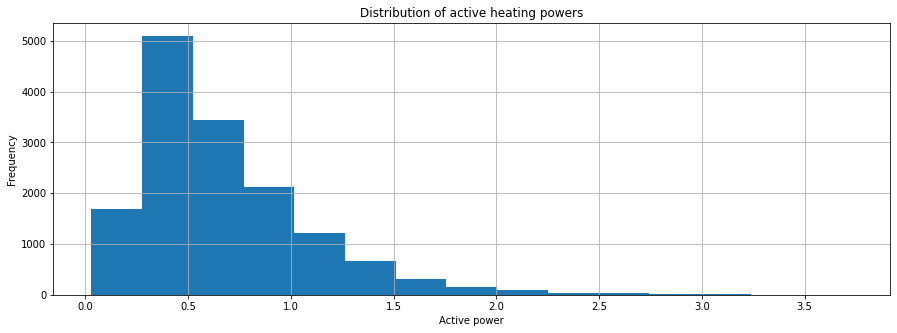

In [10]:
# histogram of active power distribution
data_arc['active_power'].hist(bins=15,figsize=(15,5))
plt.title('Distribution of active heating powers')
plt.ylabel('Frequency')
plt.xlabel('Active power')

   
ACTIVE power (P = U * I) is the useful part of the power, the part that determines the direct conversion of electrical energy into other necessary types of energy. In fact active power determines the rate of useful energy consumption.
    
-------------------------------------------------- -----------------------------------------------------------------------------
    
Power that constantly flows back and forth between source and load is known as REACTIVE (Q). Reactive power is the power that is consumed and then returned by the load due to its reactive properties. Reactive power is usually "harmful" or "stray".

Judging by the histogram most often there were 5 heating iterations for one batch.

Text(0.5, 0, 'Number of iterations')

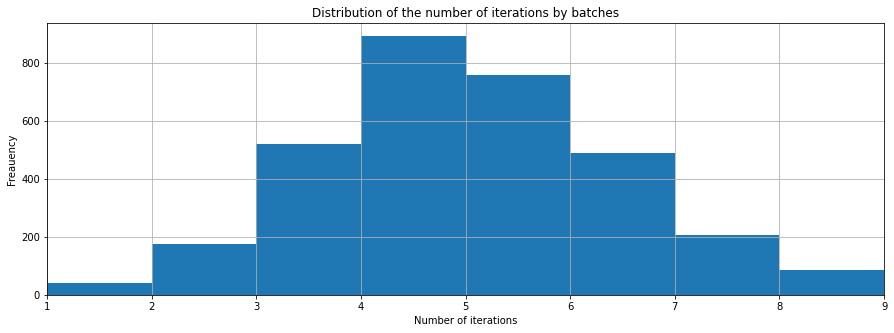

In [11]:
# Plot of a histogram Distribution of the number of iterations by batches
data_arc.groupby('key')['active_power'].count().hist(bins=15,figsize=(15,5))
plt.xlim(det_whiskers(data_arc.groupby('key')['active_power'].count()))
plt.title('Distribution of the number of iterations by batches')
plt.ylabel('Freauency')
plt.xlabel('Number of iterations')

It can be seen from the statistical summary that the minimum value for the characteristic "reactive_power" is negative.
Based on information obtained in the public domain, reactive power can be negative if the load is active-capacitive in nature. (If the current lags behind the voltage the phase shift is considered positive if it is ahead it is negative).

Let's check how often negative values are found in the feature 'reactive_power'. To do this the feature 'reactive_power' was sorted in ascending order. You can see that there is only one negative value in the 'data_arc' dataset. Perhaps this surge was formed during a sharp drop in voltage.
In order not to delete the data of the entire batch, we will build the dependence 'active_power' vs 'reactive_power' and, using the trendline equation, we will get a new value instead of a negative one.

In [12]:
# checking the number of negative values
display(data_arc.sort_values(by='reactive_power', ascending=True).head(10))

# checking the values of reactive power in the batch with a negative number
display(data_arc[data_arc['key'] == 2116])

,key,strt_arc_heat,end_arc_heat,active_power,reactive_power
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
5596,1216,2019-06-16 08:22:19,2019-06-16 08:22:30,0.030188,0.020806
2419,521,2019-05-22 17:42:57,2019-05-22 17:43:11,0.030563,0.021154
4914,1060,2019-06-11 04:31:57,2019-06-11 04:32:08,0.031630,0.022485
4633,1000,2019-06-09 01:17:44,2019-06-09 01:17:57,0.038186,0.022983
676,146,2019-05-08 19:18:55,2019-05-08 19:19:07,0.035400,0.023228
4063,873,2019-06-04 18:34:19,2019-06-04 18:34:30,0.040905,0.023569
6580,1432,2019-06-23 21:13:19,2019-06-23 21:13:34,0.034053,0.025329
8704,1892,2019-07-09 18:51:37,2019-07-09 18:51:50,0.038364,0.026079
4615,996,2019-06-08 22:06:27,2019-06-08 22:09:03,0.035165,0.026222


,key,strt_arc_heat,end_arc_heat,active_power,reactive_power
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


None


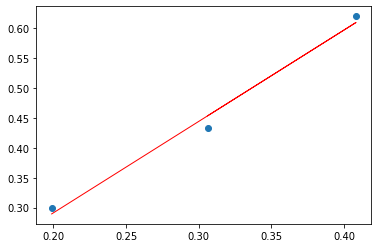

In [13]:
# 'active_power' vs 'reactive_power' relationship
def plot_relationship(data):    
    x = data.query("key == 2116 and reactive_power > 0")['reactive_power'].to_list()
    y = data.query("key == 2116 and reactive_power > 0")['active_power'].to_list()

    #create scatterplot
    plt.scatter (x, y)

    #calculate equation for trendline
    z = np.polyfit (x, y, 1)
    p = np.poly1d (z)

    #add trendline to plot
    plt.plot (x, p(x), color="red", linewidth=1 , linestyle="-")
    
print(plot_relationship(data_arc))

None

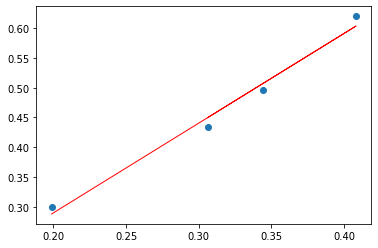

In [14]:
# this relationship is better described by the logarithmic function f(x)=0.2861*ln(x) + 0.5438

data_arc.at[9780, 'reactive_power'] = 0.2877 * m.log(0.496) + 0.5461
display(plot_relationship(data_arc))

<Figure size 432x288 with 0 Axes>

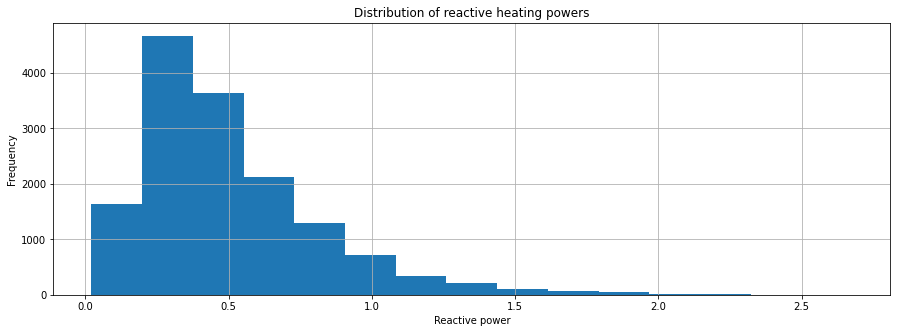

<Figure size 432x288 with 0 Axes>

In [15]:
# histogram Distribution of reactive heating powers
data_arc['reactive_power'].hist(bins=15,figsize=(15,5))
plt.title('Distribution of reactive heating powers')
plt.ylabel('Frequency')
plt.xlabel('Reactive power')
plt.figure()

The "data_arc" has been studied and processed:
- no data gaps found
- column names have been renamed
- one negative value was found in column 'reactive_power'. It was calculated from 'reactive_power' vs 'active_power' relationship

Next you need to find:
- total heating time;
- number of heating starts;
- total active and reactive powers;
- full power in each batch.

In [16]:
# For each batch we find the total active and reactive powers
pivot_arc = data_arc.pivot_table(index='key', values=['active_power', 'reactive_power'], aggfunc='sum')
# pivot_arc

In [17]:
# electrode heating time in each iteration
data_arc['heat_time'] = data_arc['end_arc_heat'] - data_arc['strt_arc_heat']

# For each batch we find the total heating time
pivot_arc['heat_time'] = data_arc.groupby('key')['heat_time'].sum()
# pivot_arc.head()

# Convert heating time to seconds
def seconds(row):
    return row.total_seconds()
pivot_arc['heat_time'] = pivot_arc['heat_time'].apply(seconds)
# pivot_arc.head()

# full power for each batch
pivot_arc['full_power'] = ((pivot_arc['active_power']) ** 2 + (pivot_arc['reactive_power']) ** 2) ** 0.5
display(pivot_arc)

,active_power,reactive_power,heat_time,full_power
key,,,,
1,4.878147,3.183241,1098.0,5.824889
2,3.052598,1.998112,811.0,3.648398
3,2.525882,1.599076,655.0,2.989502
4,3.209250,2.060298,741.0,3.813674
5,3.347173,2.252643,869.0,4.034596
...,...,...,...,...
3237,3.932467,2.828459,909.0,4.844014
3238,2.106529,1.681182,546.0,2.695151
3239,4.666754,3.111617,1216.0,5.608989


<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ ТИМЛИДА</b></u></p>
    <p>супер, согласен.</p>
</div>

In [18]:
pivot_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 1 to 3241
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   active_power    3214 non-null   float64
 1   reactive_power  3214 non-null   float64
 2   heat_time       3214 non-null   float64
 3   full_power      3214 non-null   float64
dtypes: float64(4)
memory usage: 125.5 KB


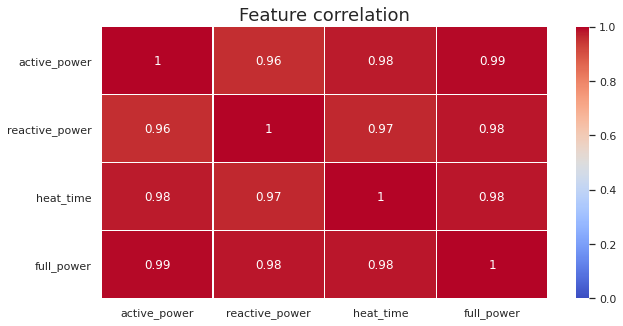

In [19]:
pivot_arc_corr = pivot_arc.corr()
sb.set_theme()
f,ax=plt.subplots(figsize=(10,5))
sb.heatmap(pivot_arc_corr, annot=True, linewidths=.5,vmin=0.0, vmax=1, cmap='coolwarm')
plt.title("Feature correlation", fontsize=18)
plt.show()

Further in the work we will use the "pivot_arc" table to combine and train models.
It will include:
- active power;
- reactive power;
- heating time in seconds;
- full power.

At the last stage of data processing it will be possible to exclude some of these features to prevent multicolliner. As can be seen from the correlation matrix all parameters in the "pivot_arc" dataset are highly correlated with each other.

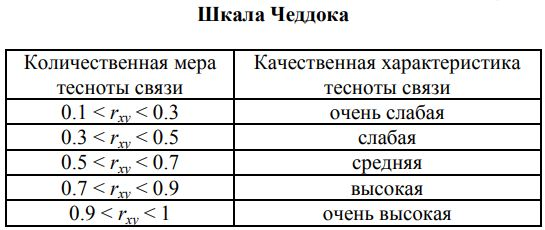

### DATASET № 2: data_bulk (bulk material feed data (объём))

In [20]:
get_dataset_description(data_bulk)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


The structure of the "data_bulk_time" and "data_bulk" tables is the same. This also applies to wire data tables.
Omissions indicate that the material was not used in the production process of some batches.
There are a lot of materials in the tables about bulk materials "data_bulk" and about wire "data_wire" that are rarely used.
We will take into the model only those data where the gaps are no more than 90% of the total length of the dataset.
Thus, the following will be taken into the model: 6,4,3,15,12,14 bulk materials

Редко использующиеся материалы: ['Bulk 8', 'Bulk 13', 'Bulk 9', 'Bulk 2', 'Bulk 7', 'Bulk 5', 'Bulk 10', 'Bulk 11', 'Bulk 1']
Часто использующиеся материалы: ['Bulk 6', 'Bulk 4', 'Bulk 3', 'Bulk 15', 'Bulk 12', 'Bulk 14']


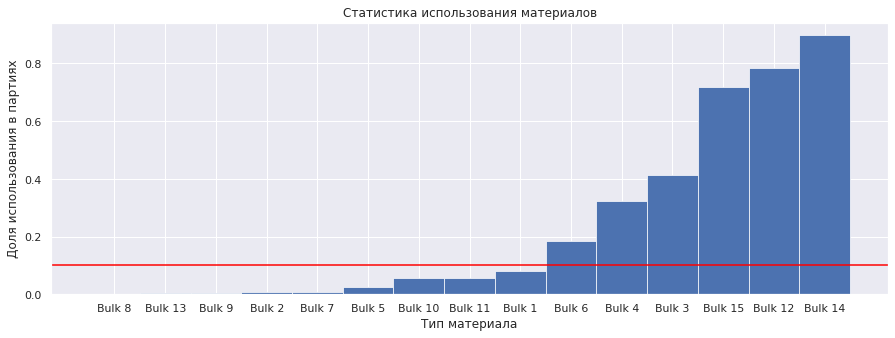

In [21]:
# using the feature to detect rarely used materials
material_in_use(data_bulk)

In [22]:
# Feature names need to be altered
data_bulk.columns = ['key','Bulk_1','Bulk_2','Bulk_3','Bulk_4','Bulk_5','Bulk_6','Bulk_7','Bulk_8'\
                     ,'Bulk_9','Bulk_10','Bulk_11',\
                     'Bulk_12','Bulk_13','Bulk_14','Bulk_15']

In [23]:
# The remaining Nan will be replaced by zero values. We will assume that at a certain point in time they were not used.
data_bulk = data_bulk.fillna(0)

In [24]:
# remove rarely used materials from the dataset
data_bulk = data_bulk.drop(columns = ['Bulk_8','Bulk_13','Bulk_9','Bulk_2','Bulk_7','Bulk_5','Bulk_10','Bulk_11','Bulk_1'],axis = 1)

In [25]:
# find the sum of all materials for a particular batch
# data_bulk['sum_bulk'] = data_bulk[['Bulk_6', 'Bulk_4', 'Bulk_3', 'Bulk_15', 'Bulk_12', 'Bulk_14']].sum(axis=1)

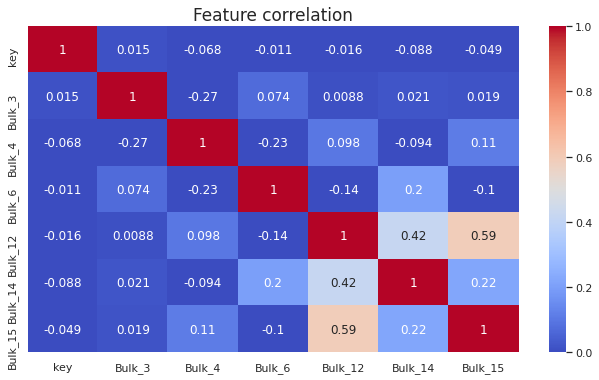

In [26]:
data_bulk_corr = data_bulk.corr()
f,ax=plt.subplots(figsize=(11,6))
sb.heatmap(data_bulk_corr, annot=True,vmin=0, vmax=1, cmap='coolwarm')
plt.title("Feature correlation", fontsize=17)
plt.show()

Let's take for training the model:
- Bulk 6
- Bulk 4
- Bulk 3
- Bulk 15
- Bulk 12
- Bulk 14

Multicolnearity between the features of bulk materials was not found.

### DATASET № 3: data_bulk_time (bulk material feed data (time))

Since we need to solve a problem not about time series the time factor will not be involved in training the model.

In [27]:
get_dataset_description(data_bulk_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [28]:
# Feature names need to be altered

data_bulk_time.columns = ['key','Bulk_1','Bulk_2','Bulk_3','Bulk_4','Bulk_5','Bulk_6','Bulk_7','Bulk_8'\
                     ,'Bulk_9','Bulk_10','Bulk_11',\
                     'Bulk_12','Bulk_13','Bulk_14','Bulk_15']
# display(data_bulk_time)


In [29]:
# remove rarely used materials from the dataset
data_bulk_time = data_bulk_time.drop(columns = ['Bulk_8','Bulk_13','Bulk_9','Bulk_2','Bulk_7','Bulk_5','Bulk_10','Bulk_11','Bulk_1'],axis = 1)

### DATASET № 4: data_gas (alloy gas purge data)

In [30]:
get_dataset_description(data_gas)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [31]:
# Feature names need to be altered

data_gas.columns = ['key','gas']
# display(data_gas)

(0.0083985291, 23.86)

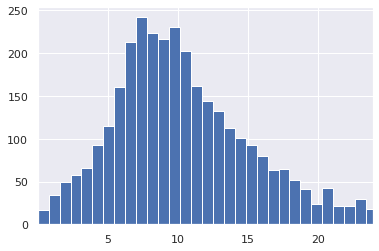

In [32]:
data_gas['gas'].hist(bins=100)
plt.xlim(det_whiskers(data_gas['gas']))

Removed the replacement of outliers with the median in gas data. No gaps were found in these data so we take them into work in their entirety.

### DATASET № 5: data_temp (temperature measurement results)

In [33]:
get_dataset_description(data_temp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


Examining the distribution, it can be seen that the data has a small dispersion. It follows that for our alloy the temperature changes within small limits. We conclude that the outliers can also be replaced by the median. Choosing the median as it is not affected by outliers. 


In [34]:
# Feature names need to be altered

data_temp.columns = ['key','measure_time','temperature']
# display(data_temp)

<AxesSubplot:>

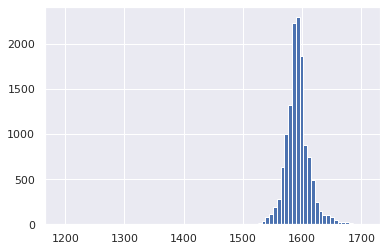

In [35]:
data_temp['temperature'].hist(bins=80)

(1551.0, 1631.0)

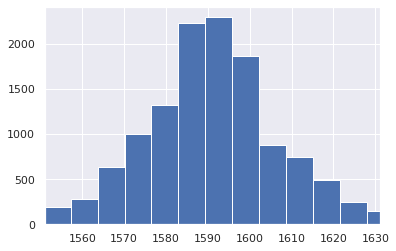

In [36]:
data_temp['temperature'].hist(bins=80)
plt.xlim(det_whiskers(data_temp['temperature']))

In [37]:
data_temp[data_temp['temperature'] < 1300] = data_temp['temperature'].median()

Next, the last measured batch temperature should be selected as a target feature. If there is no such temperature then you will have to delete the data of the entire lot since the temperature is the target feature. The first batch temperature can be used as one of the features.
Intermediate temperature measurements are not planned to be used in the model.

In [38]:
# Replace all missing temperature values with zeros then delete the values of all batches where temperature = 0
data_temp = data_temp.fillna(value=0)

In [39]:
# take the first temperature measurement time for each batch
first_temp = data_temp.pivot_table(index='key',values=['measure_time', 'temperature'], aggfunc='first')

In [40]:
# take the latest temperature measurement time for each batch
last_temp = data_temp.pivot_table(index='key',values=['measure_time', 'temperature'], aggfunc='last')

In [41]:
# We merge the data "first_temp" and "last_temp" by the key of the batch
overall_temp = first_temp.merge(last_temp, left_on='key',right_on='key')
overall_temp.columns = ['first_time','first_temp', 'last_time', 'last_temp']
# overall_temp

In [42]:
overall_temp

,first_time,first_temp,last_time,last_temp
key,,,,
1.0,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
2.0,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0
3.0,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0
4.0,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0
5.0,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0
...,...,...,...,...
3237.0,2019-08-31 22:44:04,1569.0,2019-08-31 23:05:43,0.0
3238.0,2019-08-31 23:30:31,1584.0,2019-08-31 23:43:00,0.0
3239.0,2019-09-01 01:31:47,1598.0,2019-09-01 02:24:15,0.0


### DATASET № 6: data_wire (wire materials data (volume))

In [43]:
get_dataset_description(data_wire)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are a lot of materials in the tables about bulk materials "data_bulk" and about wire "data_wire" that are rarely used.
We will take into the model only those data where the gaps are no more than 90% of the total length of the dataset.
Thus the following will be taken into the model: 2 and 1 wire materials for alloying.

Редко использующиеся материалы: ['Wire 5', 'Wire 7', 'Wire 4', 'Wire 8', 'Wire 9', 'Wire 3', 'Wire 6']
Часто использующиеся материалы: ['Wire 2', 'Wire 1']


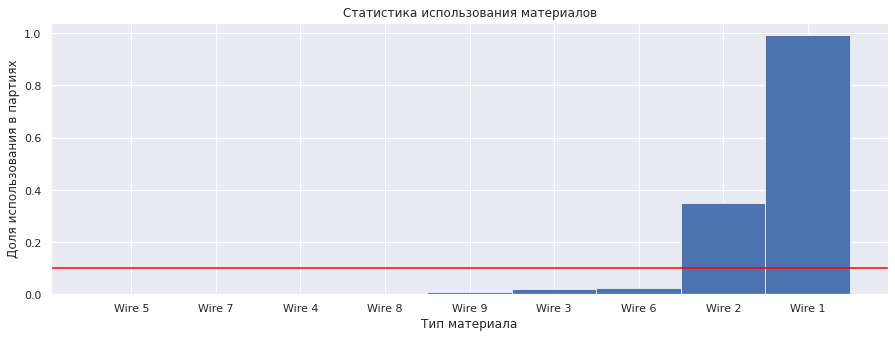

In [44]:
material_in_use(data_wire)

In [45]:
# Feature names need to be altered

data_wire.columns = ['key','wire_1','wire_2','wire_3','wire_4','wire_5','wire_6','wire_7','wire_8','wire_9']
# display(data_wire)

In [46]:
# Fill in the gaps with zeros
data_wire = data_wire.fillna(0)

In [47]:
# remove rarely used materials from the dataset
data_wire = data_wire.drop(columns = ['wire_5', 'wire_7', 'wire_4', 'wire_8', 'wire_9', 'wire_3', 'wire_6'], axis = 1)

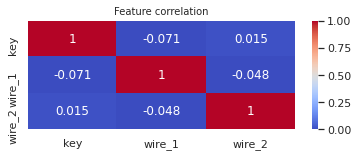

In [48]:
data_wire_corr = data_wire.corr()
f,ax=plt.subplots(figsize=(6,2))
sb.heatmap(data_wire_corr, annot=True, vmin=0, vmax=1, cmap='coolwarm')
plt.title("Feature correlation", fontsize=10)
plt.show()

Let's take for training the model:
- Wire 1
- wire 2

No multicollinearity found in data

### DATASET № 7: data_wire_time (wire material data (time))

In [49]:
get_dataset_description(data_wire)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3081 non-null   float64
 2   wire_2  3081 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 72.3 KB


None

,key,wire_1,wire_2
count,3081.000000,3081.000000,3081.000000
mean,1623.426485,100.044411,17.712733
std,932.996726,42.841120,33.517734
min,1.000000,0.000000,0.000000
25%,823.000000,70.281120,0.000000
50%,1619.000000,100.114563,0.000000
75%,2434.000000,125.798405,23.162880
max,3241.000000,330.314424,282.780152


,key,wire_1,wire_2
0,1,60.059998,0.00000
1,2,96.052315,0.00000
2,3,91.160157,0.00000
3,4,89.063515,0.00000
4,5,89.238236,9.11456


In [50]:
# Feature names need to be altered

data_wire_time.columns = ['key','wire_1','wire_2','wire_3','wire_4','wire_5','wire_6','wire_7','wire_8','wire_9']
# display(data_wire_time)

In [51]:
# remove rarely used materials from the dataset
data_wire_time = data_wire_time.drop(columns = ['wire_5', 'wire_7', 'wire_4', 'wire_8', 'wire_9', 'wire_3', 'wire_6'],axis = 1)

In [52]:
# connect dataframes of values and time
data_wire_overall = data_wire.merge(data_wire_time, left_on='key', right_on='key')

In [53]:
# create a table for training with alloying materials
material_alloyage = data_bulk.merge(data_wire, left_on='key', right_on='key')
material_alloyage = material_alloyage.set_index('key')
material_alloyage

,Bulk_3,Bulk_4,Bulk_6,Bulk_12,Bulk_14,Bulk_15,wire_1,wire_2
key,,,,,,,,
1,0.0,43.0,0.0,206.0,150.0,154.0,60.059998,0.00000
2,0.0,73.0,0.0,206.0,149.0,154.0,96.052315,0.00000
3,0.0,34.0,0.0,205.0,152.0,153.0,91.160157,0.00000
4,0.0,81.0,0.0,207.0,153.0,154.0,89.063515,0.00000
5,0.0,78.0,0.0,203.0,151.0,152.0,89.238236,9.11456
...,...,...,...,...,...,...,...,...
3237,170.0,0.0,0.0,252.0,130.0,206.0,38.088959,0.00000
3238,126.0,0.0,0.0,254.0,108.0,106.0,56.128799,0.00000
3239,0.0,0.0,114.0,158.0,270.0,88.0,143.357761,0.00000


### Data aggregation

Four dataframes were prepared for model training.They need to be combined. We will merge according to the batch key.

In [54]:
# join 4 tables. The main table for training will be "data"

data_1 = pivot_arc.merge(overall_temp, left_on='key', right_on='key')
data_2 = material_alloyage.merge(data_gas, left_on='key', right_on='key')
data = data_1.merge(data_2, left_on='key', right_on='key')

Our target function is the output temperature.
It is necessary to remove batches where the outlet temperature is zero.

In [55]:
# delete these parties
data = data.query('last_temp != 0')

# converting the time data type to "datetime"

data['first_time'] = pd.to_datetime(data['first_time'])
data['last_time'] = pd.to_datetime(data['last_time'])

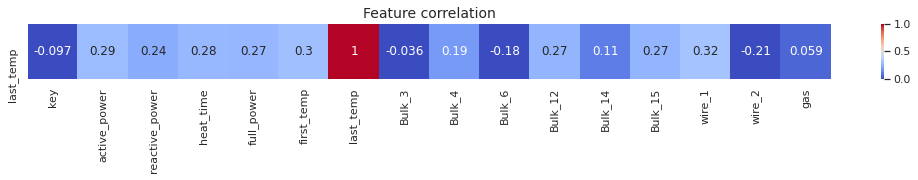

In [56]:
data_corr = data.corr()
f,ax=plt.subplots(figsize=(18,1))
sb.heatmap(data_corr.sort_values(by='last_temp', ascending=False).head(1), annot=True, vmin=0, vmax=1, cmap='coolwarm')
plt.title("Feature correlation", fontsize=14)
plt.show()

Three traits correlate with the outlet temperature in almost the same way, while they are similar in nature:
- reactive_power;
- active_power;
- full_power.

Let's leave the most correlated - active_power. We will delete the rest.

We will also check the general table for multicollinearity. It can be seen that there are strongly correlated features "active_power", "heat_time", "reactive_power", "full_power". Let's leave only "active_power" since it correlates best with the target parameter.

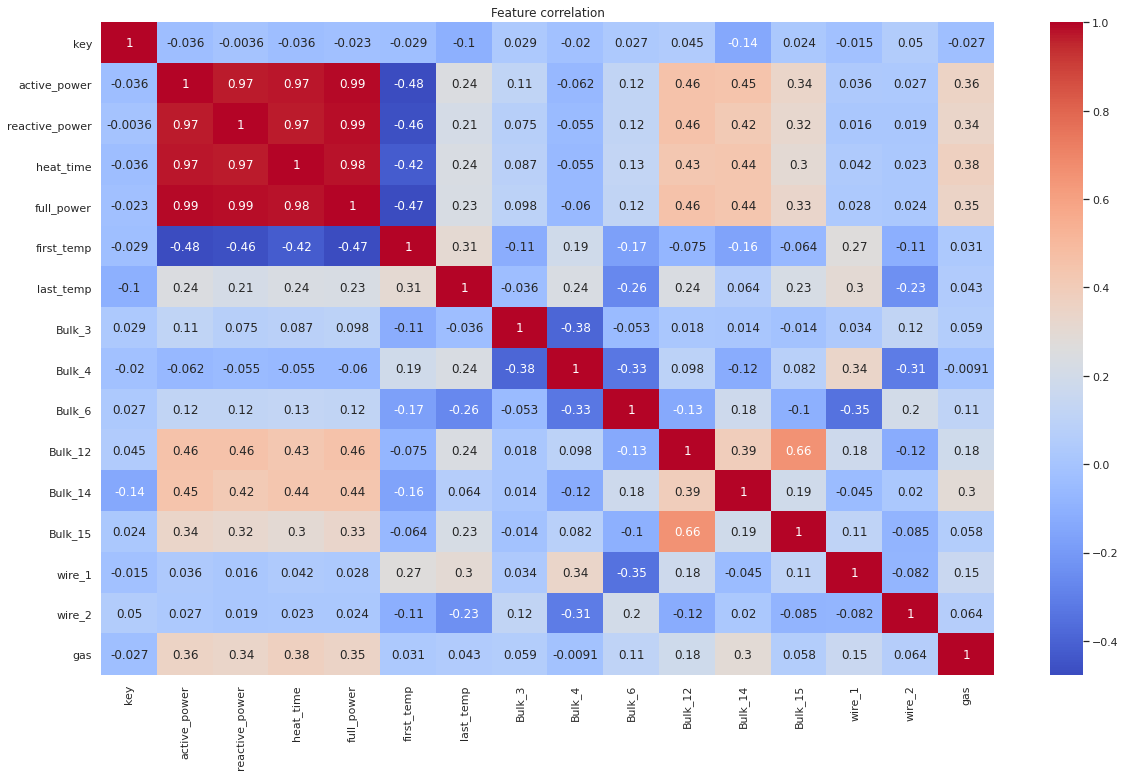

In [57]:
plt.figure(figsize=(20, 12))
plt.title('Feature correlation')
sb.heatmap(data.corr(method='spearman'), annot = True, cmap="coolwarm")
plt.show()

In [58]:
data = data.drop(columns = ['reactive_power','full_power','first_time','last_time','key','heat_time'])
data = data.reset_index(drop=True)

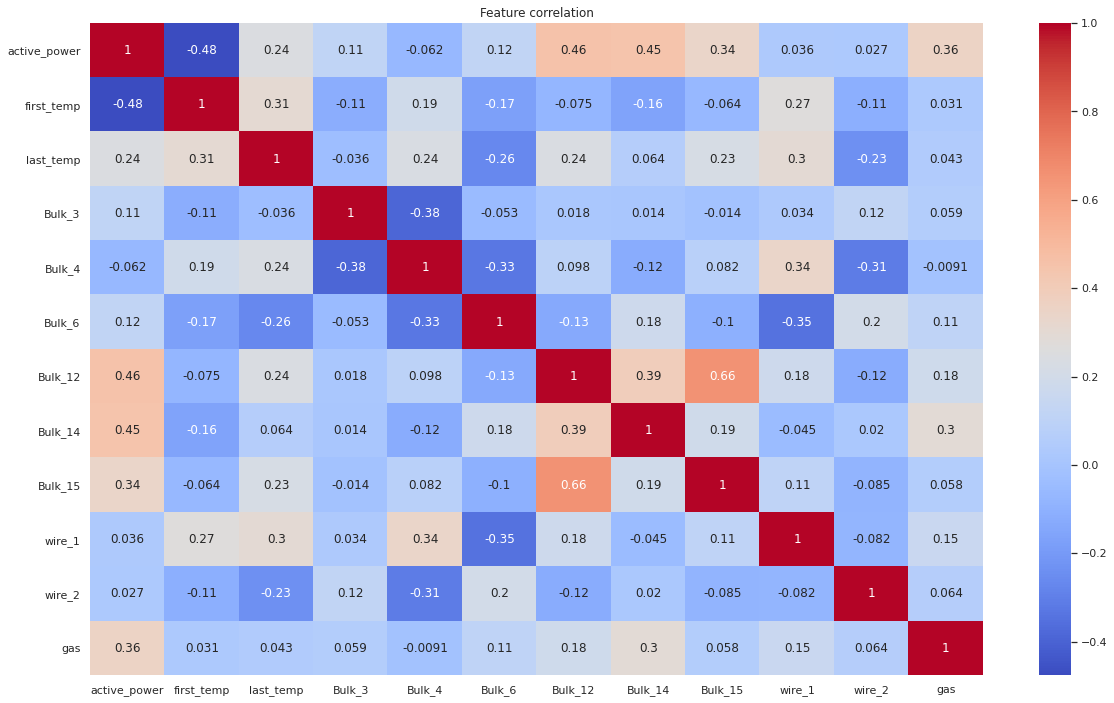

In [59]:
plt.figure(figsize=(20, 12))
plt.title('Feature correlation')
sb.heatmap(data.corr(method='spearman'), annot = True, cmap="coolwarm")
plt.show()

In [60]:
get_dataset_description(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2329 entries, 0 to 2328
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   active_power  2329 non-null   float64
 1   first_temp    2329 non-null   float64
 2   last_temp     2329 non-null   float64
 3   Bulk_3        2329 non-null   float64
 4   Bulk_4        2329 non-null   float64
 5   Bulk_6        2329 non-null   float64
 6   Bulk_12       2329 non-null   float64
 7   Bulk_14       2329 non-null   float64
 8   Bulk_15       2329 non-null   float64
 9   wire_1        2329 non-null   float64
 10  wire_2        2329 non-null   float64
 11  gas           2329 non-null   float64
dtypes: float64(12)
memory usage: 218.5 KB


None

,active_power,first_temp,last_temp,Bulk_3,Bulk_4,Bulk_6,Bulk_12,Bulk_14,Bulk_15,wire_1,wire_2,gas
count,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000
mean,3.152449,1587.388579,1593.363246,47.348218,37.303564,22.430228,208.415629,153.853585,119.952769,102.443601,17.609859,11.375600
std,1.425290,23.619908,11.200889,75.310430,58.643238,55.790873,157.062272,81.404354,84.640443,43.539993,33.624771,6.392041
min,0.186226,1519.000000,1541.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008399
25%,2.173277,1571.000000,1587.000000,0.000000,0.000000,0.000000,105.000000,105.000000,0.000000,73.207679,0.000000,7.282948
50%,3.028334,1587.000000,1593.000000,0.000000,0.000000,0.000000,206.000000,149.000000,107.000000,101.119201,0.000000,10.100950
75%,3.920676,1603.000000,1598.000000,80.000000,77.000000,0.000000,282.000000,204.000000,204.000000,128.091599,23.102560,14.216688
max,17.496497,1660.000000,1653.000000,454.000000,281.000000,503.000000,1849.000000,636.000000,405.000000,330.314424,282.780152,77.995040


,active_power,first_temp,last_temp,Bulk_3,Bulk_4,Bulk_6,Bulk_12,Bulk_14,Bulk_15,wire_1,wire_2,gas
0,4.878147,1571.0,1613.0,0.0,43.0,0.0,206.0,150.0,154.0,60.059998,0.00000,29.749986
1,3.052598,1581.0,1602.0,0.0,73.0,0.0,206.0,149.0,154.0,96.052315,0.00000,12.555561
2,2.525882,1596.0,1599.0,0.0,34.0,0.0,205.0,152.0,153.0,91.160157,0.00000,28.554793
3,3.209250,1601.0,1625.0,0.0,81.0,0.0,207.0,153.0,154.0,89.063515,0.00000,18.841219
4,3.347173,1576.0,1602.0,0.0,78.0,0.0,203.0,151.0,152.0,89.238236,9.11456,5.413692


In [61]:
data

,active_power,first_temp,last_temp,Bulk_3,Bulk_4,Bulk_6,Bulk_12,Bulk_14,Bulk_15,wire_1,wire_2,gas
0,4.878147,1571.0,1613.0,0.0,43.0,0.0,206.0,150.0,154.0,60.059998,0.00000,29.749986
1,3.052598,1581.0,1602.0,0.0,73.0,0.0,206.0,149.0,154.0,96.052315,0.00000,12.555561
2,2.525882,1596.0,1599.0,0.0,34.0,0.0,205.0,152.0,153.0,91.160157,0.00000,28.554793
3,3.209250,1601.0,1625.0,0.0,81.0,0.0,207.0,153.0,154.0,89.063515,0.00000,18.841219
4,3.347173,1576.0,1602.0,0.0,78.0,0.0,203.0,151.0,152.0,89.238236,9.11456,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...
2324,3.210690,1570.0,1591.0,21.0,0.0,0.0,256.0,129.0,223.0,89.150879,0.00000,7.125735
2325,4.203064,1554.0,1591.0,0.0,63.0,0.0,256.0,129.0,226.0,114.179527,0.00000,9.412616
2326,2.212379,1571.0,1589.0,0.0,85.0,0.0,230.0,124.0,226.0,94.086723,9.04800,6.271699
2327,3.408725,1591.0,1594.0,90.0,0.0,0.0,206.0,129.0,207.0,118.110717,0.00000,14.953657


## Selection of Machine Learning algorithm and Neural Network

In [62]:
# Let's single out the variable features and the feature to be predicted for each table
features = data.drop('last_temp', axis=1)
target = data['last_temp']

# Separate the validation set (30%) from the original data
X_train, X_test, y_train, y_test = train_test_split(features,target, test_size=0.3, random_state=281122)

### Linear Regression

First we scale the data in terms of the standard deviation for linear regression since there is a difference in dimensionality

In [63]:
scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X_train)

In [64]:
%%time

model_linear_scaler = None
model_linear_scaler = LinearRegression()
model_linear_scaler.fit(X_train_scaler, y_train)
mae_linear_scaler1 = ms.cross_val_score(model_linear_scaler, X_train_scaler, y_train, scoring='neg_mean_absolute_error', cv=5)
mae_linear_scaler = -np.mean(mae_linear_scaler1)
print('Mean MAE of linear regression on training set with cross-validation: {:.2f}'.format(mae_linear_scaler))
print('-----------------------------------------------------------------------------------------------------------------')


Mean MAE of linear regression on training set with cross-validation: 6.29
-----------------------------------------------------------------------------------------------------------------
CPU times: user 23.1 ms, sys: 23.6 ms, total: 46.7 ms
Wall time: 16.2 ms


In [65]:
%%time

model_linear = None
model_linear = LinearRegression()
model_linear.fit(X_train, y_train)
mae_linear = ms.cross_val_score(model_linear, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
mae_linear = -np.mean(mae_linear)
print('Mean MAE of linear regression on training set with cross-validation: {:.2f}'.format(mae_linear))
print('-----------------------------------------------------------------------------------------------------------------')


Mean MAE of linear regression on training set with cross-validation: 6.29
-----------------------------------------------------------------------------------------------------------------
CPU times: user 54.2 ms, sys: 58.5 ms, total: 113 ms
Wall time: 105 ms


### Decision Tree Regressor

In [66]:
%%time

model_tree = None
parametrs = {'max_depth': range(1,15,2)}
model_tree = DecisionTreeRegressor(random_state=281122)

tree = GridSearchCV(model_tree, parametrs, scoring='neg_mean_absolute_error', cv=10, n_jobs = -1)
tree.fit(X_train, y_train)
MAE_tree = -tree.best_score_ 
print("Best Options: ",tree.best_params_)
print('-----------------------------------------------------------------------------------------------------------------')
print("Best MAE: ",(MAE_tree))
print('-----------------------------------------------------------------------------------------------------------------')

Best Options:  {'max_depth': 5}
-----------------------------------------------------------------------------------------------------------------
Best MAE:  7.123977797628669
-----------------------------------------------------------------------------------------------------------------
CPU times: user 756 ms, sys: 81.8 ms, total: 838 ms
Wall time: 880 ms


### Random Forest Regressor

In [67]:
%%time

model_forest = None
parametrs = { 
              'n_estimators': [100,200,300,400,500],
              'max_depth': range (1,11, 2), 
            }

model_forest = RandomForestRegressor(random_state=281122)
# Подбор параметров
model_forest_cv = GridSearchCV(model_forest, parametrs, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
# Обучение модели
model_forest_cv.fit(X_train, y_train)
MAE_forest = -model_forest_cv.best_score_
print(f'Best Options:{model_forest_cv.best_params_}')
print('-----------------------------------------------------------------------------------------------------------------')
print("Best MAE: ",(MAE_forest))
print('-----------------------------------------------------------------------------------------------------------------')


Best Options:{'max_depth': 9, 'n_estimators': 500}
-----------------------------------------------------------------------------------------------------------------
Best MAE:  6.149749084165185
-----------------------------------------------------------------------------------------------------------------
CPU times: user 2min 1s, sys: 565 ms, total: 2min 1s
Wall time: 2min 2s


### XGBoost

We use one of the most popular and efficient implementations of the gradient boosting algorithm on trees.
For selection of parameters we will use GridSearchCV.

In [68]:
model_xgb = XGBRegressor(random_state=281122)
params_xgb = {
               'eta' : [0.1, 0.3, 0.5],
               'max_depth' : range(2, 10,2)
    
             }

search_xgb = GridSearchCV(estimator=model_xgb, param_grid=params_xgb, scoring='neg_mean_absolute_error',verbose=0, cv=5,n_jobs = -1)
result_xgb = search_xgb.fit(X_train, y_train)
MAE_xgb = -result_xgb.best_score_

print('MAE models XGBoost:', (-result_xgb.best_score_))
print('-----------------------------------------------------------------------------------------------------------------')
print('Best XGBoost Options:', result_xgb.best_params_)


MAE models XGBoost: 6.099312886431173
-----------------------------------------------------------------------------------------------------------------
Best XGBoost Options: {'eta': 0.1, 'max_depth': 4}


At this stage of the selection of algorithms XGBoost proved to be the most positive.

### Neural Network 

A base model with three layers was created. 'relu' was chosen as the activation function since its derivative is equal to one which in turn will prevent the "signal" from fading with an increase in the number of layers. The "Adam" algorithm with a learning step of 0.005 was chosen as the optimizer.

In [69]:
def base_model():
    # model creation
    model = Sequential()
    model.add(Dense(100, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(80, activation='relu'))
    model.add(Dense(1, activation='linear'))
    optimizer = Adam(lr=0.005)
    # model compillation
    model.compile(loss='mean_squared_error', metrics = 'mean_absolute_error', optimizer=optimizer)
    return model

In [70]:
NNreg = KerasRegressor(build_fn=base_model, epochs=20, batch_size=32, verbose=1)
kfold = KFold(n_splits=5)
results = cross_val_score(NNreg, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error', n_jobs = -1)
MAE_nn = -results.mean()
NNreg.fit(X_train, y_train, epochs=10, batch_size=32)
base_model().summary()
print("Average MAE of a fully connected neural network on a training set with cross-validation:{:.2f}".format(MAE_nn))

2022-12-23 17:50:17.900056: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
41/41 [==============================] - 1s 2ms/step - loss: 224817.4062 - mean_absolute_error: 311.6625
Epoch 2/20
41/41 [==============================] - 0s 3ms/step - loss: 1909.7249 - mean_absolute_error: 33.5941
Epoch 3/20
41/41 [==============================] - 0s 4ms/step - loss: 507.8669 - mean_absolute_error: 17.7250
Epoch 4/20
41/41 [==============================] - 0s 3ms/step - loss: 486.6825 - mean_absolute_error: 17.4871
Epoch 5/20
41/41 [==============================] - 0s 4ms/step - loss: 494.6707 - mean_absolute_error: 17.4932
Epoch 6/20
41/41 [==============================] - 0s 3ms/step - loss: 470.6326 - mean_absolute_error: 17.2607
Epoch 7/20
41/41 [==============================] - 0s 3ms/step - loss: 473.7398 - mean_absolute_error: 17.1787
Epoch 8/20
41/41 [==============================] - 0s 4ms/step - loss: 480.2349 - mean_absolute_error: 17.3813
Epoch 9/20
41/41 [==============================] - 0s 3ms/step - loss: 459.1137 - mean_absolute_er

The neural network showed good results in terms of the MAE metric. But still, they are an order of magnitude lower than those of machine learning algorithms. Perhaps more attention should be paid to the selection of hyperparameters layers and neurons.

### Summarizing of model selection 

On the training set 4 machine learning algorithms and a neural network were tested. According to the results of the test the best results were shown (the smallest MAE) by the algorithm with the implementation of gradient boosting - XGBoost.

In [71]:
d = { 'Линейная регрессия(scaler)':mae_linear_scaler,
     'Линейная регрессия': mae_linear, 
     'Дерево решений': MAE_tree,
     'Случайный лес': MAE_forest,
     'XGBoost': MAE_xgb, 
     'Нейронная сеть': MAE_nn, 
     }
print(tabulate(d.items(), headers=['Имя', 'MAE'], tablefmt="grid"))

+----------------------------+----------+
| Имя                        |      MAE |
+============================+==========+
| Линейная регрессия(scaler) |  6.28753 |
+----------------------------+----------+
| Линейная регрессия         |  6.28753 |
+----------------------------+----------+
| Дерево решений             |  7.12398 |
+----------------------------+----------+
| Случайный лес              |  6.14975 |
+----------------------------+----------+
| XGBoost                    |  6.09931 |
+----------------------------+----------+
| Нейронная сеть             | 17.4053  |
+----------------------------+----------+


## BEST MODEL TEST - CHECK

Let's check the trained model using a test set.

In [72]:
prediction = result_xgb.predict(X_test)
best_case = mean_absolute_error(y_test, prediction)
print(f'MAE models on test set: {best_case}')

MAE models on test set: 6.024539450889664


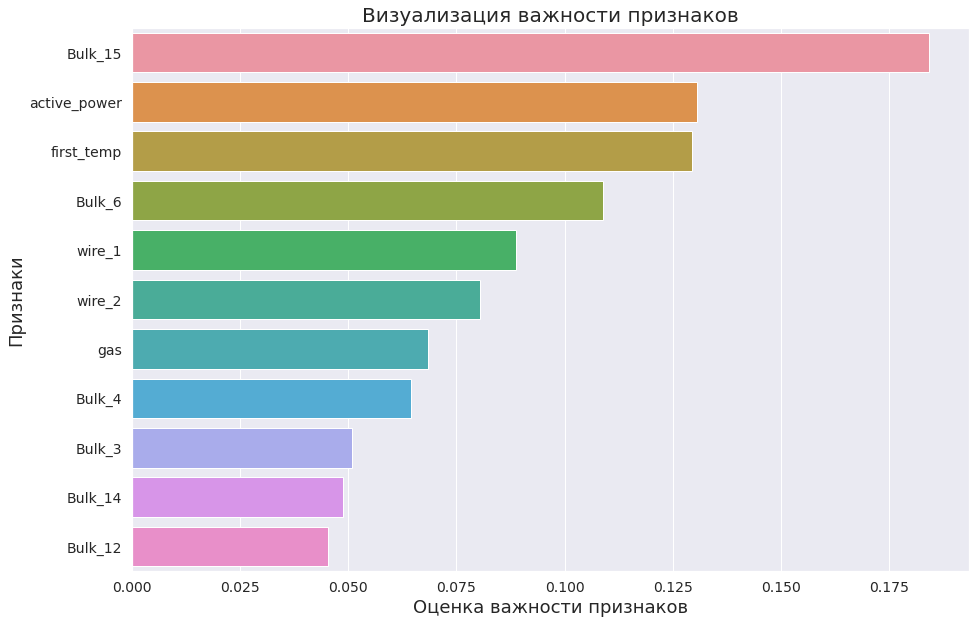

In [73]:
# plot a graph with the importance of features
chart_feature_imp(result_xgb.best_estimator_,X_train)

# Conclusion 

Each point of the plan was worked out:
  - a complete analysis of the obtained data was carried out;
  - all necessary distributions are plot;
  - heating time and full power are found ;
  - features are examined for collinearity (such features are removed);
  - "time" features were not used in training;
  - Rarely used materials have been removed from learning features;
  - anamal values were processed taking into account business requests;
  - selected features important for learning;
  - using the results of temperature measurements the initial temperature was extracted which was used as; feature as well as the output temperature which was used as a target feature when training models;

Several models were trained which showed the following results on the test set:

```python
+----------------------------+----------+
| Имя                        |      MAE |
+============================+==========+
| Линейная регрессия(scaler) |  6.28753 |
+----------------------------+----------+
| Линейная регрессия         |  6.28753 |
+----------------------------+----------+
| Дерево решений             |  7.12398 |
+----------------------------+----------+
| Случайный лес              |  6.14975 |
+----------------------------+----------+
| XGBoost                    |  6.09931 |
+----------------------------+----------+
| Нейронная сеть             | 17.0013  |
+----------------------------+----------+

```
  
For all models the parameters were selected using GridSearchCV.
RANDOM_STATE was set to "281122".
MAE was used as a metric to validate the model.
    
The data was divided into two samples:
  - training;
  - test.
    
The test set was used for the best model which showed an MAE of 6.06;
The analysis of features was also carried out according to their importance relative to the target feature for the best model.
The most important feature was "Bulk_15". Perhaps the addition of this material greatly affects the temperature. Also the second and third place is occupied by active power and the first temperature which is logical.


#  REPORT

**Task to be solved:**

In this project it was necessary to develop a predictive model for the temperature of the molten state of the alloy which will help the business to work on their costs.

Before the decision of the project a detailed plan was drawn up.

**PROJECT PLAN**

1) To build models that predict the temperature of steel it was necessary:

- Complete data preparation:
- Exploratory Data Analysis;
- process missings understand what type they belong to the method of forming missings;
- to calculate additional parameters (full power, time from the start of heating, etc.);
- It is MANDATORY to check the signs for multicollinearity (delete those that correlate with each other with a value greater than 0.7);
- build graphs and distributions for data visualization and determination of statistical outliers;
- determine the frequency of use of materials for alloying. Cut off rarely used;
- remove batches of steel where there is no target feature (outlet temperature);
- determine parameters are necessary for training models and form a table of features.

2) Train 6 models:

- Linear regression;
- Linear regression with feature scaling;
- Decision tree (regression);
- Random forest (regression);
- XGBoost:
- Fully connected neural network.

For all models it was planned to use automatic selection of parameters using GridSearchCV. RANDOM_STATE was set to "281122". MAE was used as a metric to validate the model.
The data was divided into two samples:

- training;
- test.
The test set was used for the best model;
The ranking of features according to their importance relative to the target feature for the best model was also an important event.

What was done:
  At the stage of data processing, I had to face the usual phenomena for a dataset:
- statistical outliers;
- undefined values;
- passes.
 

1) The first table has 4 characteristics, not including lot numbers. Dataset without gaps.
- Start of arc heating;
- End of arc heating;
- Active power;
- Reactive power.

Feature names have been changed:
- arc_heat;
- end_arc_heat;
- active_power;
- reactive_power.

Power distributions have been built. The total power was calculated as well as the time of heating by the arc in seconds. In the sign with reactive power, there was a negative value. Several articles were studied that made it clear that reactive power could become negative but this value was the only one in batch 2116. It was decided to build a graph of active power from reactive power and use it to replace the value through a logarithmic dependence.
A correlation matrix was also built which showed that all signs have a high connection. Later, only one of them was left.

2) The second and third were datasets with additives and alloying wire. Further in the report these datasets will be referred to as one, due to the same structure and the use of the same processing methods.
There are a lot of gaps in these datasets. It is assumed that the gaps in them mean that the additive or wire was not used in this batch at a certain point so the gaps were later replaced by zeros. A function was also written to build a ranking of alloying materials by frequency of use. It turned out that only 6 additives are used for more than 10% of batches and 2 wires for the same percentage. As a result
only the following materials will be taken into the model:
Bulk 6;
Bulk 4;
Bulk 3;
Bulk 15;
Bulk 12;
Bulk 14;
wire 1;
wire 2.
A correlation matrix has been constructed. Multicollinearity was not found.

3) Next dataset with temperature. Its median is 1591. The minimum and maximum values are 1191 and 1705 respectively. With the help of a metallurgical guide it was found that the temperature for melting steel ranges between 1300 and 1600, depending on its grade. There are about a thousand values outside the directory limit. All values below 1300 degrees were replaced by the median, but above 1600 were left, since upward deviations are quite possible. This point also needs to be discussed with the customer. The temperature distribution is also plotted, which is normal.

4) For a dataset with gas, a distribution was built. Normal. No outliers found. There are no passes. Fabulous!

5) Datasets containing time were not processed due to the fact that they will not be used in the model. In this case, the problem of time series is not solved.

• At the final stage of data preparation, the processed tables were merged;
• Removed all parties that do not have a target feature;
• Removed all features with multicollinearity (active power saved);
• Features with the "time" parameter have been removed.

At the next stage, the models described in the plan were selected and trained. At this stage of the selection of algorithms, XGBoost showed itself most positively with the metric MAE = 6.006.
Data on the metrics of other algorithms are given in the table below:
```
+----------------------------+----------+
| Name                       |    MAE   |
+============================+==========+
| Linear regression (scaler) |  6.28753 |
+----------------------------+----------+
| Linear regression          |  6.28753 |
+----------------------------+----------+
| Decision tree              |  7.12398 |
+----------------------------+----------+
| Random forest              |  6.14975 |
+----------------------------+----------+
| XGBoost                    |  6.09931 |
+----------------------------+----------+
| Neural Network             | 17.0013  |
+----------------------------+----------+
```

The test set was used for the best model; 
The analysis of features was also carried out according to their importance relative to the target feature for the best model. The most important feature was "Bulk_15". Perhaps the addition of this material greatly affects the temperature. Also, the second and third place is occupied by active power and the first temperature which is logical.